## Cluster Analysis
This book comprises a cluster analyis of the complete dataset (original) and its derived datasets (Influencers_OLS, OLS_all and uniques23 and uniques23_50), as defined in earlier notebooks. The pipeline applied is described below:

__Data Preparation:__  
    Only scaling and normalization were applied, as data cleaning was already performed in earlier steps.  
__Dimensionality Reduction:__  
    Principal Component Analysis (PCA) was used to reduce dimensionality while retaining approximately 90% of the variance.  
    This step resulted in transformed datasets with reduced feature dimensions, which were subsequently used for clustering.  
__Clustering Analysis:__  
    Clustering was performed on the transformed datasets using:   
    K-Means, with k=5 determined by the elbow method.  
    DBSCAN, for detecting clusters and outliers.  
    Gaussian Mixture Models (GMM), to capture potential non-linear structures.  
__Performance evaluation included:__   
    Internal metrics, such as Silhouette Score and Davies-Bouldin Index.  
    External metrics (where labels were available), including Adjusted Rand Index (ARI) and Homogeneity Score.  

In [108]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns


MinMaxScaler is the denominated scaler that owe to be used with this data since doesnt have gaussian distribution, however it does only work well for DBSCAN, so the StandarScaler is use in conjuction with the KMeans cluster analysis. First pipeline Scales, and reduce the dimensionality with PCA to 90% varianza, then uses 3 clustering methods( K-Means, DBSCAN, and GMM) applied on PCA-reduced data. Evaluation of the methods uses following metrics: Silhouette Score and Davies-Bouldin Index for internal evaluation. Adjusted Rand Index (ARI) for external evaluation since true labels are present.

In [109]:
#Loading the data 
pd.options.display.float_format = '{:.4f}'.format
# Read the excel file
Jointax = pd.read_excel('data/Jointax.xlsx', sheet_name='Biotot_jointax', header=[0,1,2,3,4,5,6,7] , dtype={**{i: str for i in range(0,2)},
                                                                        **{i:float for i in range(2, 884)}},  skiprows=[8]) # Somehow it was showing an empty row, so skiprow deletes it
OLS_all = pd.read_excel('data/OLS_all.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}}) 
Influencers_OLS = pd.read_excel('data/Influencers_OLS.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})
uniques_23_OLS = pd.read_excel('data/uniques_plus_23.xlsx', dtype={**{i: str for i in range(0,2)},
                                            **{i:float for i in range(2, -1)}})

In [110]:

# Making sure the sites and categories get read as they should
Jointax["Sites"]= Jointax["Sites"].astype(str)
Jointax["Category"]= Jointax["Category"].values.astype(int)
#Drop level of Kindom since it is boring
Jointax.columns = Jointax.columns.droplevel(1)
Jointax = Jointax.reset_index(drop=True)
#Setting the sites as index
Jointax = Jointax.set_index("Sites").reset_index()
# Deleting headers names of unnamed levels
Jointax.columns = Jointax.columns.map(lambda x: tuple('' if 'Unnamed' in str(level) else level for level in x))
#Drop column 1
Jointax =Jointax.drop(Jointax.columns[1], axis=1)
#Correcting the Tuple-like Index
Jointax['Sites'] = Jointax['Sites'].map(lambda x: x[0] if isinstance(x, tuple) else x)
Jointax = Jointax.set_index("Sites")

In [111]:
# We working only with the values in this notebook, still keeping the taxa 
Jointax.columns = Jointax.columns.droplevel([0,1,2,3,4,5])
original = Jointax.reset_index(drop=False)
#Reset the index
if original.columns[1] == "":
    original.rename(columns = {original.columns[1]: "Category"}, inplace=True)
original= original.set_index("Sites")

In [112]:
original.head()

,Category,1,2,3,4,5,6,7,8,9,...,873,874,875,876,877,878,879,880,881,882
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.4308,0.5170,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0215,0.0000,0.0000,0.0000,0.0000,0.0215,0.0000
site_2,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.3415,0.0000,0.0000,...,0.0190,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0190,0.0000
site_3,1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0246,0.3192,0.0000,0.0000,...,0.0123,0.0000,0.0000,0.0123,0.0000,0.0000,0.0000,0.0000,0.0246,0.0123
site_4,1,0.0000,0.0000,0.0154,0.0000,0.0000,0.0176,0.2512,0.0000,0.0000,...,0.0022,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0066,0.0022
site_5,1,0.0000,0.0000,0.0037,0.0000,0.0000,0.0221,0.5098,0.0000,0.0000,...,0.0037,0.0000,0.0037,0.0000,0.0000,0.0000,0.0000,0.0000,0.0110,0.0037


In [113]:
def clean_dataframe(df):
    return (df.drop(columns='Unnamed: 0', axis=1)
        .astype({'Sites': str, 'Category': int})
        .set_index("Sites"))

OLS_all = clean_dataframe(OLS_all)
Influencers_OLS = clean_dataframe(Influencers_OLS)
uniques_23_OLS= clean_dataframe(uniques_23_OLS)

In [114]:
Influencers_OLS.head()

,Category,678,565,23,864,712,214,549,625,863,...,526,584,725,408,91,351,375,334,871,471
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1508,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_10,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,2.4800,2.4200,0.0000,0.0000,0.0000,0.0000,0.0000
site_11,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.9210,0.0000,0.0000,0.0000,...,0.0767,0.0767,0.0000,0.2047,0.0000,0.0000,0.0000,0.0000,0.0000,5.8839
site_12,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.3021,0.0000,0.0000,0.0000,...,0.0336,0.1188,0.0000,0.0749,0.0000,0.0000,0.0000,0.0000,0.0000,1.1592
site_13,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.6947,0.0000,0.0000,0.0000,...,0.0000,0.0595,0.0000,3.1560,0.0000,0.0000,0.0000,0.0000,0.0000,0.5558


In [115]:
def clustering_pipeline_all(df, pca_data_name='pca_data', n_clusters=5, eps=0.5, min_samples=5, n_components=20):
    """
    Performs clustering using K-Means, DBSCAN, and GMM with PCA for dimensionality reduction.
    
    Parameters:
    - df: Input DataFrame (features only, no labels).
    - n_clusters: Number of clusters for K-Means and GMM (default=5).
    - eps: DBSCAN's epsilon parameter (default=0.5).
    - min_samples: Minimum samples for DBSCAN (default=5).
    - n_components: Number of components for PCA (default=2).
    
    Returns:
    - results: Dictionary with clustering results for K-Means, DBSCAN, and GMM, as well as PCA data and metrics.
    """
    results = {}
    df = df.drop(columns=['Category'])  # Drop any non-numeric columns

    # Step 1: Scaling the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df)
    
    # Step 2: PCA for dimensionality reduction
    pca = PCA(n_components=n_components)
    pca_data = pca.fit_transform(scaled_data)
    results['explained_variance'] = pca.explained_variance_ratio_
    
    # Step 3: K-Means Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(pca_data)
    kmeans_silhouette = silhouette_score(pca_data, kmeans_labels)
    kmeans_db_score = davies_bouldin_score(pca_data, kmeans_labels)
    results['kmeans'] = {
        'cluster_labels': kmeans_labels,
        'silhouette_score': kmeans_silhouette,
        'davies_bouldin_score': kmeans_db_score
    }
    
    # Step 4: DBSCAN Clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(pca_data)
    valid_indices = dbscan_labels != -1
    if len(set(dbscan_labels[valid_indices])) > 1:
        dbscan_silhouette = silhouette_score(pca_data[valid_indices], dbscan_labels[valid_indices])
        dbscan_db_score = davies_bouldin_score(pca_data[valid_indices], dbscan_labels[valid_indices])
    else:
        dbscan_silhouette = None
        dbscan_db_score = None
    results['dbscan'] = {
        'cluster_labels': dbscan_labels,
        'silhouette_score': dbscan_silhouette,
        'davies_bouldin_score': dbscan_db_score
    }
    
    # Step 5: GMM Clustering
    gmm = GaussianMixture(n_components=n_clusters, random_state=42)
    gmm_labels = gmm.fit_predict(pca_data)
    gmm_silhouette = silhouette_score(pca_data, gmm_labels)
    gmm_db_score = davies_bouldin_score(pca_data, gmm_labels)
    results['gmm'] = {
        'cluster_labels': gmm_labels,
        'silhouette_score': gmm_silhouette,
        'davies_bouldin_score': gmm_db_score
    }
    print("Explained Variance Ratio (Current PCA):", pca.explained_variance_ratio_)
    # Store PCA-transformed data with the specified name
    results[pca_data_name] = pca_data
    
    return results


In [116]:
#Running the pipeline for DataFrames: df1, df2, df3
dataframes = [original]

# Running the  pipeline for each DataFrame
clustering_results = [clustering_pipeline_all(df, n_clusters=5, eps=0.5, min_samples=5, n_components=2) for df in dataframes]

# K-Means silhouette score for abundance_all
kmeans_silhouette_abundance_all = clustering_results[0]['kmeans']['silhouette_score']

kmeans_labels_abundance_all = clustering_results[0]['kmeans']['cluster_labels']

Explained Variance Ratio (Current PCA): [0.087413   0.05488332]


In [117]:
print(kmeans_labels_abundance_all , kmeans_silhouette_abundance_all)

[1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 0 1 2 1 1 1 2 2 1 1 2 2
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 3 1 4 4 1 4 4 4 1 1 1 1 1 1 1] 0.7608976557569952


### K-means Clustering Algoritm using Corrosion Risk Labels Colors

In [118]:
def plot_clusters(pca_data, categories, method_name="Clustering"):
    plt.figure(figsize=(10, 6))
    
    # Color palette for categories
    palette = {1: 'green', 2: 'orange', 3: 'red'}
    
    sns.scatterplot(
        x=pca_data[:, 0],
        y=pca_data[:, 1],
        hue=categories,
        palette=palette,
        s=50,
        alpha=0.8,
        edgecolor="k"
    )
    plt.title(f"{method_name} Visualization (PCA Reduced)", fontsize=16)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Category", loc="best")
    plt.grid(True)
    plt.show()

In [119]:
Influencers_OLS.head()

,Category,678,565,23,864,712,214,549,625,863,...,526,584,725,408,91,351,375,334,871,471
Sites,,,,,,,,,,,,,,,,,,,,,
site_1,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.1508,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
site_10,2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,2.4800,2.4200,0.0000,0.0000,0.0000,0.0000,0.0000
site_11,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.9210,0.0000,0.0000,0.0000,...,0.0767,0.0767,0.0000,0.2047,0.0000,0.0000,0.0000,0.0000,0.0000,5.8839
site_12,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.3021,0.0000,0.0000,0.0000,...,0.0336,0.1188,0.0000,0.0749,0.0000,0.0000,0.0000,0.0000,0.0000,1.1592
site_13,3,0.0000,0.0000,0.0000,0.0000,0.0000,0.6947,0.0000,0.0000,0.0000,...,0.0000,0.0595,0.0000,3.1560,0.0000,0.0000,0.0000,0.0000,0.0000,0.5558


Explained Variance Ratio (Current PCA): [0.087413  0.0548833]


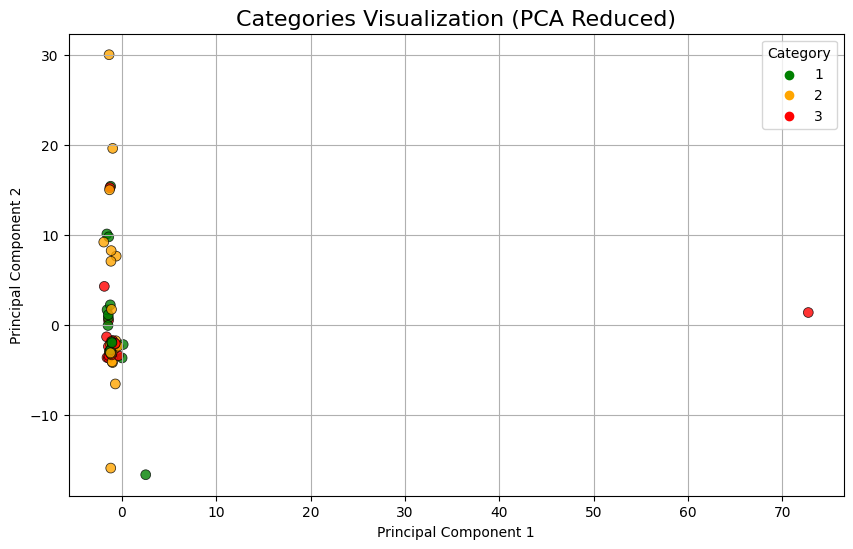

In [120]:
# Running pipeline 
results_original = clustering_pipeline_all(original,  pca_data_name='pca_data_original',  n_clusters=5, eps=0.5, min_samples=5, n_components=2)
#  Plot K-Means Clusters
pca_data_original = clustering_results[0]['pca_data']
kmeans_labels_original = clustering_results[0]['kmeans']['cluster_labels']
 
# calling the function, pass the category column
plot_clusters(pca_data_original, original['Category'], method_name="Categories")

plt.show()

Explained Variance Ratio (Current PCA): [0.19122825 0.1640954 ]


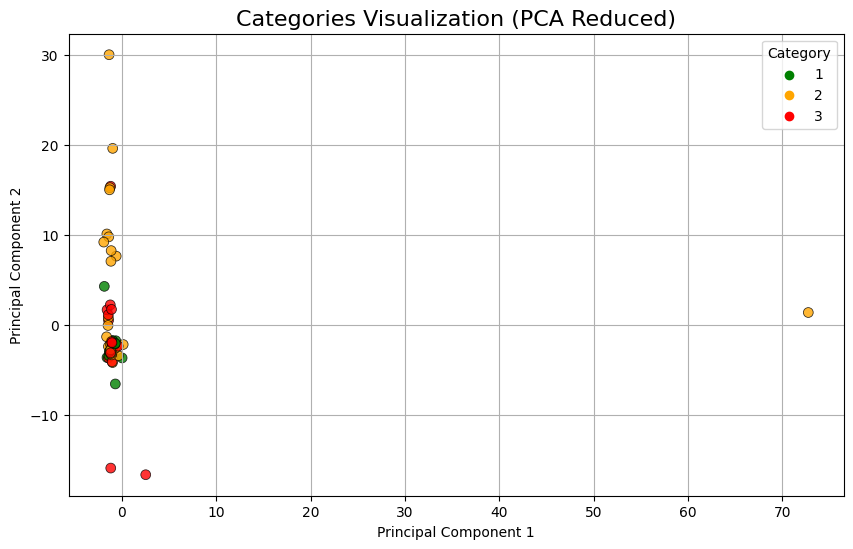

In [121]:
# Running pipeline 
results_Influencers_OLS = clustering_pipeline_all(Influencers_OLS,  pca_data_name='pca_data_Influencers_OLS',  n_clusters=5, eps=0.5, min_samples=5, n_components=2)
#  Plot K-Means Clusters
pca_data_Influencers_OLS = clustering_results[0]['pca_data']
kmeans_labels_Influencers_OLS = clustering_results[0]['kmeans']['cluster_labels']
 
# calling the function, pass the category column
plot_clusters(pca_data_Influencers_OLS, Influencers_OLS['Category'], method_name="Categories")

plt.show()

Explained Variance Ratio (Current PCA): [0.21345052 0.14838367]


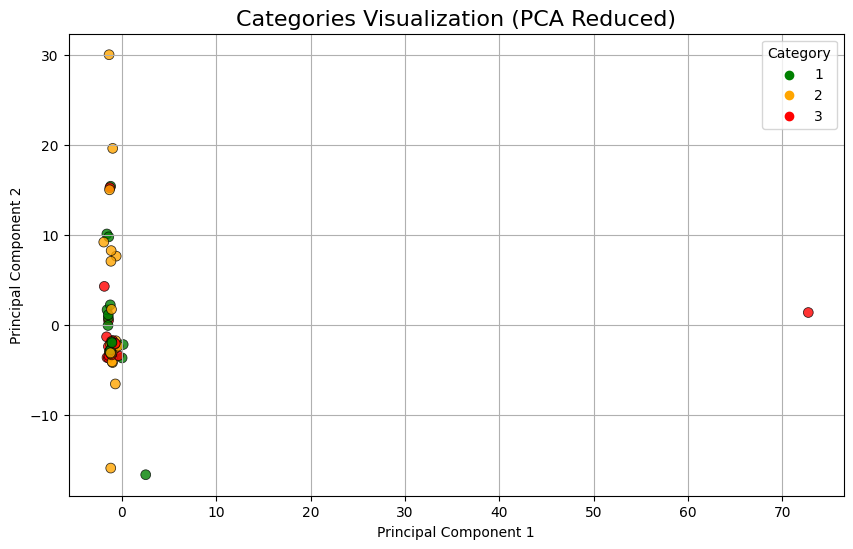

In [122]:
# Running pipeline 
results_OLS_all = clustering_pipeline_all(OLS_all,  pca_data_name='pca_data_OLS_all',  n_clusters=5, eps=0.5, min_samples=5, n_components=2)
#  Plot K-Means Clusters
pca_data_OLS_all = clustering_results[0]['pca_data']
kmeans_labels_OLS_all = clustering_results[0]['kmeans']['cluster_labels']
 
# calling the function, pass the category column
plot_clusters(pca_data_OLS_all, OLS_all['Category'], method_name="Categories")

plt.show()

Explained Variance Ratio (Current PCA): [0.1994608  0.17051355]


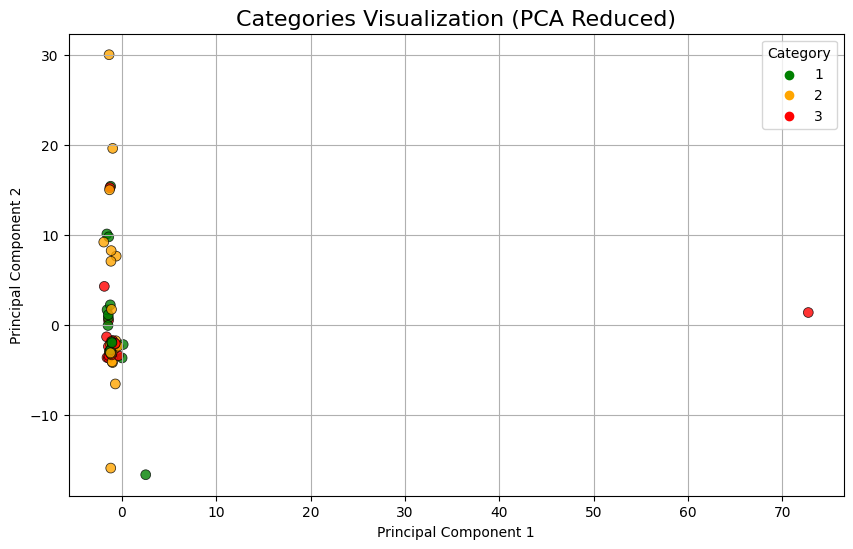

In [123]:
# Running pipeline 
results_uniques_23_OLS = clustering_pipeline_all(uniques_23_OLS,  pca_data_name='pca_data_uniques_23_OLS',  n_clusters=5, eps=0.5, min_samples=5, n_components=2)
#  Plot K-Means Clusters
pca_data_uniques_23_OLS = clustering_results[0]['pca_data']
kmeans_labels_uniques_23_OLS = clustering_results[0]['kmeans']['cluster_labels']
 
# calling the function, pass the category column
plot_clusters(pca_data_uniques_23_OLS, uniques_23_OLS['Category'], method_name="Categories")

plt.show()

Visualising the colors of the blobs produced by the own clusters 

In [ ]:
def plot_cluster_results(X_pca, cluster_labels, title):
    pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
    pca_df['Cluster'] = cluster_labels
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x="PC1", y="PC2", hue="Cluster", palette='tab10', data=pca_df, alpha=0.8
    )
    plt.title(title)
    plt.legend(loc='best')
    plt.show()


In [ ]:
plot_cluster_results(pca_data, results['kmeans']['cluster_labels'], "K-Means Clustering Results (PCA Reduced)")
plot_cluster_results(pca_data, results['dbscan']['cluster_labels'], "DBSCAN Clustering Results (PCA Reduced)")
plot_cluster_results(pca_data, results['gmm']['cluster_labels'], "GMM Clustering Results (PCA Reduced)")


Second pipeline will use both scalers MinMaxScaler better suitable for DBSCAN and StandarScaler better for KMeans

In [124]:
# Define scalers and clustering methods
scalers = [("StandardScaler", StandardScaler()), ("MinMaxScaler", MinMaxScaler())]
clustering_methods = [
    ("DBSCAN", DBSCAN(eps=0.5, min_samples=5)),
    ("KMeans", KMeans(n_clusters=5, random_state=42))
]

results = []

# Loop through scalers and clustering methods
for scaler_name, scaler in scalers:
    for cluster_name, clusterer in clustering_methods:
        pipeline = Pipeline([
            ("scaler", scaler),
            ("clustering", clusterer)
        ])
        # Fit the pipeline
        pipeline.fit(df.drop(columns=["categories", "Sites"]))

        # Retrieve cluster labels
        labels = pipeline["clustering"].labels_

        # Filter noise for DBSCAN
        if cluster_name == "DBSCAN" and -1 in labels:
            labels = labels[labels != -1]

        # Evaluate metrics if clustering is valid
        if len(np.unique(labels)) > 1:  # Ensure we have more than one cluster
            silhouette = silhouette_score(df.drop(columns=["categories", "Sites"]), labels)
            davies_bouldin = davies_bouldin_score(df.drop(columns=["categories", "Sites"]), labels)
        else:
            silhouette, davies_bouldin = None, None

        # Store results
        results.append({
            "Scaler": scaler_name,
            "Clustering Method": cluster_name,
            "Silhouette Score": silhouette,
            "Davies-Bouldin Index": davies_bouldin
        })

NameError: name 'MinMaxScaler' is not defined

In [ ]:
# Display results
import pandas as pd
results_df_original = pd.DataFrame(results_)
print(results_df)

## t-SNE for Visualization
t-SNE is a non-linear dimensionality reduction technique that is particularly effective for visualizing high-dimensional data in 2D or 3D. It often preserves local structure better than PCA

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

def tsne_visualization(df, labels, perplexity=30, n_components=2, random_state=42):
    """
    Visualizes data using t-SNE.
    
    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - perplexity: Perplexity for t-SNE (default=30).
    - n_components: Number of components for t-SNE (default=2).
    - random_state: Random seed for reproducibility.
    """
    tsne = TSNE(n_components=n_components, perplexity=perplexity, random_state=random_state)
    tsne_result = tsne.fit_transform(df)
    
    tsne_df = pd.DataFrame(data=tsne_result, columns=['Component 1', 'Component 2'])
    tsne_df['Category'] = labels.values  # Add the category/cluster labels
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='Component 1', y='Component 2', hue='Category',
        palette='tab10', data=tsne_df, alpha=0.8
    )
    plt.title('t-SNE Visualization')
    plt.legend(loc='best')
    plt.show()


## UMAP for Visualization
UMAP (Uniform Manifold Approximation and Projection) is another excellent method for non-linear dimensionality reduction.

In [ ]:
from umap import UMAP

def umap_visualization(df, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42):
    """
    Visualizes data using UMAP.
    
    Parameters:
    - df: Scaled DataFrame or numpy array (features only).
    - labels: Cluster or category labels to color-code.
    - n_neighbors: Number of neighbors for UMAP (default=15).
    - min_dist: Minimum distance between points (default=0.1).
    - n_components: Number of components for UMAP (default=2).
    - random_state: Random seed for reproducibility.
    """
    umap = UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_result = umap.fit_transform(df)
    
    umap_df = pd.DataFrame(data=umap_result, columns=['Component 1', 'Component 2'])
    umap_df['Category'] = labels.values  # Add the category/cluster labels
    
    # Plotting
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x='Component 1', y='Component 2', hue='Category',
        palette='tab10', data=umap_df, alpha=0.8
    )
    plt.title('UMAP Visualization')
    plt.legend(loc='best')
    plt.show()


In [ ]:
# t-SNE with K-Means labels
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_scaled)
tsne_visualization(X_scaled, kmeans.labels_, perplexity=30, n_components=2)

# UMAP with GMM labels
gmm = GaussianMixture(n_components=3, random_state=42).fit(X_scaled)
umap_visualization(X_scaled, gmm.predict(X_scaled), n_neighbors=15)
